In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygaia

from scipy import integrate
from scipy.optimize import newton
import scipy.optimize as so
from matplotlib import gridspec
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib import colors as clrs
from matplotlib.lines import Line2D

from _skysub import parellipse

import matplotlib as mpl

import sys
sys.path.append("../code/")
from orbit import get_ra_dec
import const as c


mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'serif'

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12
mpl.rc('font', size=SMALL_SIZE)          # controls default text sizes
mpl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
mpl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
mpl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
mpl.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

### Figure 1 - Horizon Distance

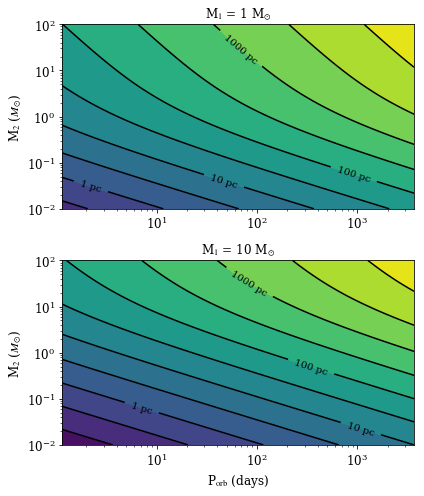

In [2]:
G = 6.674e-8
Msun = 1.989e33
AUincm = 1.496e13
pcincm = 3.086e18
secday = 24.0*3600

theta_c = 1.0e-3 # in asec




def horizon_distance(P_orb, M1=0.8, M2=4.8):

    M_tot = M1 + M2
    
    dist = 1.0 / theta_c * M2 / M_tot * (G * M_tot*Msun)**(1./3.) / AUincm * (P_orb/(2.0 * np.pi))**(2./3.)
    
    return dist




fig, ax = plt.subplots(2, 1, figsize=(6, 7))



P_orb_set = np.logspace(5, 8.5, 100)
M2_set = np.logspace(-2, 2, 100)

M2_set_2D = np.tile(M2_set, (1,100))
M2_set_2D = np.reshape(M2_set_2D, (100, 100)).T





for i, M1_test in enumerate([1.0, 10.0]):
    
    x_axis = P_orb_set
    y_axis = M2_set**2 / (M1_test + M2_set)

    XX, YY = np.meshgrid(x_axis, y_axis)

    levels = np.linspace(-1.5, 5, 14)

    dist = horizon_distance(XX, M1=M1_test, M2=M2_set_2D)
    

    p1 = ax[i].contourf(XX/secday, M2_set_2D, np.log10(dist), levels=levels, vmin=-1.5, vmax=4.5)
    p2 = ax[i].contour(XX/secday, M2_set_2D, np.log10(dist), levels=levels, colors='k', zorder=10, linestyles='solid')

    ax[i].set_xlim(1.0e5/secday, 10**8.5/secday)
    ax[i].set_ylim(1.0e-2, 1.0e2)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

    
        
    if int(M1_test) == M1_test:
        ax[i].set_title(r'M$_1$ = '+str(int(M1_test))+r' M$_{\odot}$', fontsize=12)
    else:
        ax[i].set_title(r'M$_1$ = '+str(M1_test)+r' M$_{\odot}$', fontsize=12)

    if i == 1: ax[i].set_xlabel(r'P$_{\rm{orb}}$ (days)')
    ax[i].set_ylabel(r'M$_2$ ($M_{\odot}$)')
        
        
        
    fmt = {}
    for l in p2.levels:
        if l >= 0.0 and l < 4.0:
            fmt[l] = str(int(10.0**l)) + ' pc'
    
    ax[i].clabel(p2, p2.levels[3:10:2], inline=True, fmt=fmt)
    
        
plt.tight_layout()
# plt.savefig("../figures/horizon_distance.pdf")
plt.show()

### Figure 2 - Astrometric, Radial velocity orbits

In [33]:
def a_to_P(M1, M2, a):
    mu = c.G * (M1 + M2)
    n = np.sqrt(mu/(a**3))
    return 2.0*np.pi / n

def P_to_a(M1, M2, P):
    mu = c.G * (M1 + M2)
    n = 2.0*np.pi / P
    return np.power(mu/(n*n), 1.0/3.0)

def derivs(x, t, M1, M2):
    
    sep = np.sqrt((x[0]-x[2])**2 + (x[1]-x[3])**2)
    
    dxdt = np.zeros(len(x))
    
    dxdt[0] = x[4]
    dxdt[1] = x[5]
    dxdt[2] = x[6]
    dxdt[3] = x[7]
    
    dxdt[4] = -c.G*M2/sep**3 * (x[0]-x[2])
    dxdt[5] = -c.G*M2/sep**3 * (x[1]-x[3])
    dxdt[6] = -c.G*M1/sep**3 * (x[2]-x[0])
    dxdt[7] = -c.G*M1/sep**3 * (x[3]-x[1])
    
    return dxdt

def get_x_init(M1, M2, a):
    
    x = np.zeros(8)
    
    r1 = a * M2 / (M1+M2)
    r2 = a * M1 / (M1+M2)
    
    V_orb = np.sqrt(c.G * (M1 + M2) / a)

    x[0] = r1 
    x[1] = 0.0
    x[2] = -r2
    x[3] = 0.0

    x[4] = 0.0
    x[5] = V_orb * M2 / (M1 + M2)
    x[6] = 0.0
    x[7] = -V_orb * M1 / (M1 + M2)
    
    return x

In [34]:
M1 = 1.0*c.Msun
M2 = 0.2*c.Msun
a = 1.0 * c.AUincm
P_orb = a_to_P(M1, M2, a)

# for use later on
r1 = M2 / (M1 + M2) * a
C0 = (P_orb/(2.0*np.pi))**(-2./3.) / c.G**(1./3.) * r1
t_tmp = np.linspace(0.0, 2.0*P_orb, 1000)


x0 = get_x_init(M1, M2, a)
output_1 = integrate.odeint(derivs, x0, t_tmp, args=(M1, M2))





M2 = 0.4*c.Msun
M1 = (M2/C0)**(3./2.) - M2
a = P_to_a(M1, M2, P_orb)
print(M1/c.Msun, M2/c.Msun)

x0 = get_x_init(M1, M2, a)
output_2 = integrate.odeint(derivs, x0, t_tmp, args=(M1, M2))


M2 = 0.6*c.Msun
M1 = (M2/C0)**(3./2.) - M2
a = P_to_a(M1, M2, P_orb)
print(M1/c.Msun, M2/c.Msun)

x0 = get_x_init(M1, M2, a)
output_3 = integrate.odeint(derivs, x0, t_tmp, args=(M1, M2))

2.9941125496954277 0.4000000000000001
5.635382907247955 0.6


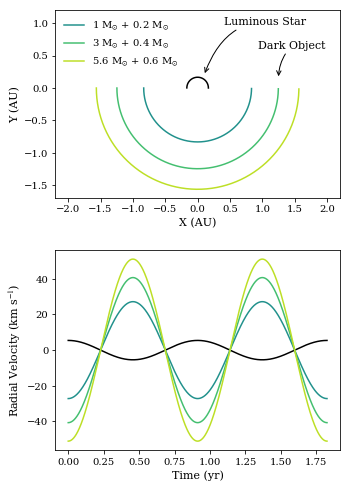

In [36]:
SMALL_SIZE = 11
MEDIUM_SIZE = 11
BIGGER_SIZE = 11
mpl.rc('font', size=SMALL_SIZE)          # controls default text sizes
mpl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
mpl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
mpl.rc('xtick', labelsize=10)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=10)    # fontsize of the tick labels
mpl.rc('legend', fontsize=10)    # legend fontsize
mpl.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title




fig, ax = plt.subplots(2, 1, figsize=(5,7))


viridis = plt.get_cmap('viridis') 
cNorm  = clrs.Normalize(vmin=0, vmax=1.0)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=viridis)

colorVal_1 = scalarMap.to_rgba(0.5)
colorVal_2 = scalarMap.to_rgba(0.7)
colorVal_3 = scalarMap.to_rgba(0.9)



ax[0].plot(output_1[:250,0]/c.AUincm, output_1[:250,1]/c.AUincm, 
           color='k')
ax[0].plot(output_1[:250,2]/c.AUincm, output_1[:250,3]/c.AUincm, 
           color=colorVal_1, label=r'1 M$_{\odot}$ + 0.2 M$_{\odot}$')
ax[0].plot(output_2[:250,2]/c.AUincm, output_2[:250,3]/c.AUincm, color=colorVal_2, 
           label=r'3 M$_{\odot}$ + 0.4 M$_{\odot}$')
ax[0].plot(output_3[:250,2]/c.AUincm, output_3[:250,3]/c.AUincm, color=colorVal_3, 
           label=r'5.6 M$_{\odot}$ + 0.6 M$_{\odot}$')

ax[0].set_xlabel(r'X (AU)')
ax[0].set_ylabel(r'Y (AU)')

ax[0].set_aspect('equal')


ax[0].legend(frameon=False, ncol=1, loc=2)
ax[0].set_xlim(-2.2, 2.2)
ax[0].set_ylim(-1.7, 1.2)


ax[0].annotate('Luminous Star', xy=(0.1, 0.2),  xycoords='data',
               xytext=(20, 50), textcoords='offset points',
               arrowprops=dict(arrowstyle="->",
                               connectionstyle="angle3,angleA=0,angleB=-110"),
               )
ax[0].annotate('Dark Object', xy=(1.25, 0.15),  xycoords='data',
               xytext=(-20, 30), textcoords='offset points',
               arrowprops=dict(arrowstyle="->",
                               connectionstyle="arc3,rad=.2"),
               )



ax[1].plot(t_tmp/c.secyer, output_1[:,5]/1.0e5, color='k')
ax[1].plot(t_tmp/c.secyer, output_1[:,7]/1.0e5, color=colorVal_1)
ax[1].plot(t_tmp/c.secyer, output_2[:,7]/1.0e5, color=colorVal_2)
ax[1].plot(t_tmp/c.secyer, output_3[:,7]/1.0e5, color=colorVal_3)

ax[1].set_xlabel("Time (yr)")
ax[1].set_ylabel(r"Radial Velocity (km s$^{-1}$)")


plt.tight_layout()
# plt.savefig("../figures/mass_degeneracy_orbital_integration.pdf")
plt.show()

### Figure 3 - Mass degeneracy

In [19]:
def hist2d(x, y, xrange=None, yrange=None, bins=30, alpha=0.3, color='C0', filled=True, quad=True, ax=False):

    # Need this function
    def find_confidence_interval(x, pdf, confidence_level):
        return pdf[pdf > x].sum() - confidence_level
    

    if xrange is None: xrange = [min(x), max(x)]    
    if yrange is None: yrange = [min(y), max(y)]
    
    data_range = (xrange, yrange)
    H, xedges, yedges = np.histogram2d(x, y, bins=(bins,bins), 
                                       range=data_range, normed=True)

    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,bins))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((bins,1))
    pdf = (H*(x_bin_sizes*y_bin_sizes))

    if quad: 
        levels = [0.25, 0.5, 0.75]
    else:
        levels = [0.68, 0.95, 0.99]
        
    level_1 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, levels[0]))
    level_2 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, levels[1]))
    level_3 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, levels[2]))
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    
    
    if ax:
        plot_obj = ax
    else:
        plot_obj = plt
    
    if filled:
        # Plot contours
        levels = [1.0, level_1, level_2, level_3]
        contour = plot_obj.contourf(X, Y, Z, levels=levels[::-1], origin="lower", colors=color,
                                    rasterized=True, alpha=alpha)
        # Plot contours
        levels = [1.0, level_1, level_2]
        contour = plot_obj.contourf(X, Y, Z, levels=levels[::-1], origin="lower", colors=color,
                                    rasterized=True, alpha=alpha)
        # Plot contours
        levels = [1.0, level_1]
        contour = plot_obj.contourf(X, Y, Z, levels=levels[::-1], origin="lower", colors=color,
                                    rasterized=True, alpha=alpha)
    else:
        # Plot contours
        levels = [1.0, level_1, level_2, level_3]
        contour = plot_obj.contour(X, Y, Z, levels=levels[::-1], origin="lower", colors=color,
                                   rasterized=True, alpha=alpha)
        # Plot contours
        levels = [1.0, level_1, level_2]
        contour = plot_obj.contour(X, Y, Z, levels=levels[::-1], origin="lower", colors=color,
                                   rasterized=True, alpha=alpha)
        # Plot contours
        levels = [1.0, level_1]
        contour = plot_obj.contour(X, Y, Z, levels=levels[::-1], origin="lower", colors=color,
                                   rasterized=True, alpha=alpha)

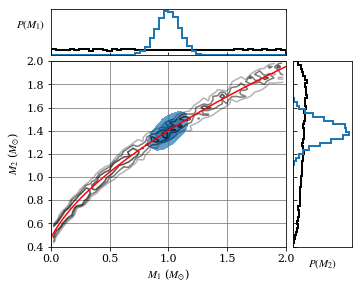

In [21]:
SMALL_SIZE = 11
MEDIUM_SIZE = 11
BIGGER_SIZE = 11
mpl.rc('font', size=SMALL_SIZE)          # controls default text sizes
mpl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
mpl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
mpl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
mpl.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def get_1_sigma_limits(x):

    x_sorted = np.sort(x)
    x_median = x_sorted[int(0.5*len(x))]
    x_low = x_sorted[int(0.16*len(x))]
    x_high = x_sorted[int(0.84*len(x))]

    return x_low, x_median, x_high



plt.figure(figsize=(5, 4))




gs = gridspec.GridSpec(2, 2,
                       width_ratios=[4, 1],
                       height_ratios=[1, 4]
                       )

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])




xrange = (0, 2)
yrange = (0.4, 2.0)



M1 = 1.0
M2 = 1.4



C_true = M2**3 / (M1+M2)**2
C = np.random.normal(C_true, 0.1*C_true, size=10000)


# Generate fake M1
N_samples = len(C)

tmp_M1 = np.random.uniform(low=0, high=2.0, size=N_samples)


# Calculate M2
def func_M2(M2, M1, C):
    return M1 - np.sqrt(M2**3 / C) + M2


# Loop through M1
tmp_M2 = np.zeros(len(tmp_M1))
for i in range(len(tmp_M1)):
    tmp_M2[i] = newton(func_M2, M2+1.0e-2, args=(tmp_M1[i], C[i]))

    
line_M2 = np.linspace(yrange[0], yrange[1], 100)
line_M1 = np.sqrt(line_M2**3 / C_true) - line_M2
ax2.plot(line_M1, line_M2, color='r')


hist2d(tmp_M1, tmp_M2, xrange=xrange, yrange=yrange, bins=50, color='k', filled=False, quad=True, ax=ax2)


ax1.hist(tmp_M1, range=xrange, bins=50, histtype='step', linewidth=2.0, color='k', normed=True)
ax3.hist(tmp_M2, range=yrange, bins=50, histtype='step', linewidth=2.0, color='k', orientation='horizontal', normed=True)



# Now constraints for a 10% mass measurement on M1
tmp_M1 = np.random.normal(M1, 0.1*M1, len(C))
tmp_M2 = np.zeros(len(tmp_M1))
for i in range(len(tmp_M1)):
    tmp_M2[i] = newton(func_M2, M2, args=(tmp_M1[i], C[i]))

hist2d(tmp_M1, tmp_M2, xrange=xrange, yrange=yrange, bins=30, color='C0', alpha=0.7, filled=True, quad=True, ax=ax2)



ax1.hist(tmp_M1, range=xrange, bins=50, histtype='step', linewidth=2.0, color='C0', normed=True)
ax3.hist(tmp_M2, range=yrange, bins=50, histtype='step', linewidth=2.0, color='C0', orientation='horizontal', normed=True)



ax2.set_axisbelow(True)
ax2.yaxis.grid(color='gray', linestyle='solid')
ax2.xaxis.grid(color='gray', linestyle='solid')
    
    
ax1.tick_params(direction='in')
ax3.tick_params(direction='in')

# ax2.set_yticks(np.linspace(0, 2, 5))

ax2.set_xlim(xrange)
ax2.set_ylim(yrange)

ax2.set_xlabel(r'$M_1$ ($M_{\odot}$)')
ax2.set_ylabel(r'$M_2$ ($M_{\odot}$)')

ax1.set_xlim(xrange)
ax3.set_ylim(yrange)

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax1.set_yticks([])
ax3.set_xticks([])

ax1.set_ylabel(r'$P(M_1)$', rotation='horizontal', labelpad=20)
ax3.set_xlabel(r'$P(M_2)$', labelpad=10)


M2_low, M2_median, M2_high = get_1_sigma_limits(tmp_M2)
# print((M2_high - M2_low)/2.0)



plt.subplots_adjust(hspace=0.05, wspace=0.05, top=0.95, right=0.96)


# plt.savefig("../figures/Mass_constraint_NS.pdf")
plt.show()

### Figure 4 - Model results

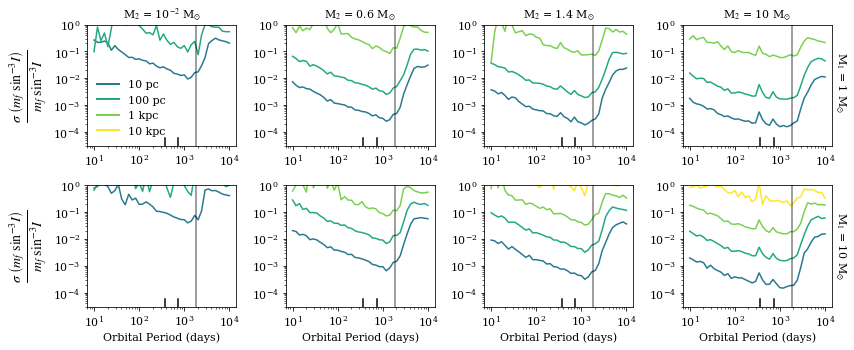

In [29]:
SMALL_SIZE = 11
MEDIUM_SIZE = 11
BIGGER_SIZE = 11
mpl.rc('font', size=SMALL_SIZE)          # controls default text sizes
mpl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
mpl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
mpl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
mpl.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def get_C_err(M1, M2, flatchain):
    

    # sys_ra, sys_dec, Omega, omega, I, tau, e, P, M1, M2, distance, pm_ra, pm_dec

    I_out = flatchain[:,4]
    e_out = flatchain[:,6]
    P_out = flatchain[:,7]
    M1_out = flatchain[:,8]/c.Msun
    M2_out = flatchain[:,9]/c.Msun

    A = (c.G*(M1_out + M2_out)*c.Msun * (P_out/(2.0*np.pi))**2)**(1./3.)/c.Rsun

    A_min = (1.0-e_out) * A * c.Rsun * M2_out / (M1_out + M2_out)
    A_max = (1.0+e_out) * A * c.Rsun * M2_out / (M1_out + M2_out)


    M_term = A_min / (1.0-e_out) * (P_out / (2.0*np.pi))**(-2/3.) / c.G**(1/3.)

    m_f = (A_min / (1.0-e_out))**3 * (P_out / (2.0*np.pi))**(-2) * np.sin(I_out)**3 / c.G
    m_f = np.abs(m_f)


    C = M2_out**3 / (M1_out + M2_out)**2
    
    C_low, C_median, C_high = get_1_sigma_limits(C)
    
    C_actual = M2**3 / (M1+M2)**2
            
    return (C_high - C_low)/2.0 / C_actual


fig, ax = plt.subplots(2, 4, figsize=(12, 5))


viridis = plt.get_cmap('viridis') 
cNorm  = clrs.Normalize(vmin=0, vmax=1.0)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=viridis)

colorVal_1 = scalarMap.to_rgba(0.4)
colorVal_2 = scalarMap.to_rgba(0.6)
colorVal_3 = scalarMap.to_rgba(0.8)
colorVal_4 = scalarMap.to_rgba(1.0)

colors = [colorVal_1, colorVal_2, colorVal_3, colorVal_4]



P_orb = np.logspace(1, 4, 40)

for j, M1 in enumerate([1, 10]):
    
    for k, M2 in enumerate([1.0e-2, 0.6, 1.4, 10.0]):
    
#         if M2 < 1.0: continue
    
        for l, d in enumerate([10, 100, 1000, 10000]):
                
            if d==10000 and M1 == 1: continue
                
    
            C_err_over_C = np.zeros(len(P_orb))
            for i, P in enumerate(P_orb):
                try:
                    chains = np.load("../data/metropolis/M1_%i"%M1 + "_M2_%.3f"%M2 + "_dist_%i"%d + "_Porb_%.3f"%P + "_chains.npy")

                    chains = chains[:,10:,:]
                    n_chains, n_steps, n_var = chains.shape
                    flatchain = chains.reshape((n_chains*n_steps, n_var))

                    C_err_over_C[i] = get_C_err(M1, M2, flatchain)


                except:
                    pass
                    


            ax[j,k].plot(P_orb, C_err_over_C, color=colors[l])

        if j==1: ax[j,k].set_xlabel('Orbital Period (days)')
        if k==0: ax[j,k].set_ylabel(r'$\sigma_C$ (M$_{\odot}$)')

        ax[j,k].set_xscale('log')
        ax[j,k].set_yscale('log')   
        ax[j,k].set_ylim(3.0e-5, 1.0)
        
ax[0,0].set_title(r"M$_2$ = 10$^{-2}$ M$_{\odot}$")
ax[0,1].set_title(r"M$_2$ = 0.6 M$_{\odot}$")
ax[0,2].set_title(r"M$_2$ = 1.4 M$_{\odot}$")
ax[0,3].set_title(r"M$_2$ = 10 M$_{\odot}$")


ax[0,0].set_ylabel(r'$\frac{\sigma\ \left(m_f\ \sin^{-3} I \right)}{m_f\ \sin^{-3} I}$', fontsize=20)
ax[1,0].set_ylabel(r'$\frac{\sigma\ \left(m_f\ \sin^{-3} I \right)}{m_f\ \sin^{-3} I}$', fontsize=20)

ax[0,3].text(1.01, 0.7, r'M$_1$ = 1 M$_{\odot}$', 
            color='k', rotation=270, transform=ax[0,3].transAxes, fontsize=11)
ax[1,3].text(1.01, 0.7, r'M$_1$ = 10 M$_{\odot}$', 
             color='k', rotation=270, transform=ax[1,3].transAxes, fontsize=11)



custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[2], lw=2),
                Line2D([0], [0], color=colors[3], lw=2)]

ax[0,0].legend(custom_lines, ['10 pc', '100 pc', '1 kpc', '10 kpc'], frameon=False)


for j in range(4):
    for i in range(2):
        y_min, y_max = ax[i,j].get_ylim()
        ax[i,j].plot([365.25,365.25],[y_min, 2.0*y_min], color='k')
        ax[i,j].plot([2.*365.25,2.*365.25],[y_min, 2.0*y_min], color='k')        
        ax[i,j].axvline(5.0*365.25, color='k',alpha=0.5, linestyle='solid')        

        
plt.tight_layout()
# plt.savefig("../figures/model_constraints.pdf")
plt.show()

### Figure 5 - Parallax, orbit, proper motion confusion

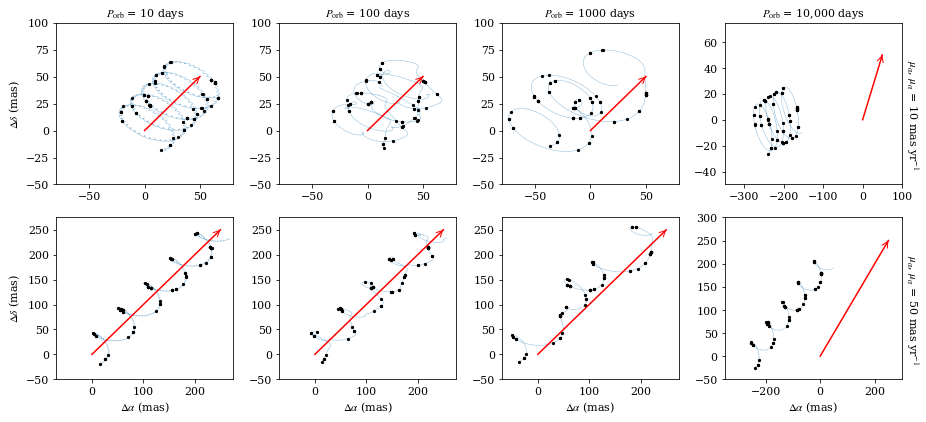

In [6]:
SMALL_SIZE = 11
MEDIUM_SIZE = 11
BIGGER_SIZE = 11
mpl.rc('font', size=SMALL_SIZE)          # controls default text sizes
mpl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
mpl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
mpl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
mpl.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

data = np.genfromtxt("../data/cadence/J1102.csv", delimiter=',', names=True)


ra, dec = 165.5728333, 41.2209444
J2000 = 2451545
epoch = 2000

# convert from decimal degrees to decimal hours
ra = ra / 360.0 * 24.0

pm_ra_1 = 10.0
pm_dec_1 = 10.0

pm_ra_2 = 50.0
pm_dec_2 = 50.0

pm_ra_3 = 100.0
pm_dec_3 = 100.0




def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))-1
    if direction == 'right':
#         end_ind = start_ind + 1
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )

    
    



fig, ax = plt.subplots(2, 4, figsize=(13,6))

N_samples = 30000


jd = data['ObservationTimeAtBarycentreBarycentricJulianDateInTCB']
jd_zero = np.min(jd)







jd = np.linspace(0, 5*365.25, N_samples) + jd_zero
N_samples = len(jd)

parallax = 28.8


ra_out = np.zeros(N_samples)
dec_out = np.zeros(N_samples)


# Start by calculating the parallax motion
for i in range(N_samples):
    output = parellipse(jd[i], ra, dec, epoch, 0.0, 0.0)

    ra_out[i] += output[0] * parallax
    dec_out[i] += output[1] * parallax
    

    
# Now add proper motion
ra_out_1 = ra_out + pm_ra_1 * (jd - jd_zero)/365.25
dec_out_1 = dec_out + pm_dec_1 * (jd - jd_zero)/365.25
ra_out_2 = ra_out + pm_ra_2 * (jd - jd_zero)/365.25
dec_out_2 = dec_out + pm_dec_2 * (jd - jd_zero)/365.25



linewidth = mpl.rcParams['lines.linewidth']



# Now add orbital motion
sys_ra, sys_dec = 0.0, 0.0 # We only want the coordinate differences
Omega = 0.0
omega = 0.0
I = 0.0
tau = J2000 * c.secday
e = 0.9
P = 100.0 * c.secday
gamma = 0.0 
M1 = 3.0 * c.Msun
M2 = 1.4 * c.Msun
distance = 1.0e3 / parallax

for i, P in enumerate([10.0*c.secday, 100.0*c.secday, 1000.0*c.secday, 10000.0*c.secday]):
        
    p = sys_ra, sys_dec, Omega, omega, I, tau, e, P, gamma, M1, M2, distance

    ra_orb = np.zeros(N_samples)
    dec_orb = np.zeros(N_samples)
    
    for j in range(N_samples):
        t = jd[j] * c.secday
        ra_tmp, dec_tmp = get_ra_dec(p, t)

        ra_orb[j] = ra_tmp * 3600.0 * 1.0e3
        dec_orb[j] = dec_tmp * 3600.0 * 1.0e3
        
    # Plot orbits
    ax[0,i].plot(ra_out_1+ra_orb, dec_out_1+dec_orb, linewidth=0.5, alpha=0.5)
    ax[1,i].plot(ra_out_2+ra_orb, dec_out_2+dec_orb, linewidth=0.5, alpha=0.5)


    # Add CofM motion
    line_1 = ax[0,i].plot((jd-jd_zero)/365.25*pm_ra_1, (jd-jd_zero)/365.25*pm_dec_1, color='r')[0]
    line_2 = ax[1,i].plot((jd-jd_zero)/365.25*pm_ra_2, (jd-jd_zero)/365.25*pm_dec_2, color='r')[0]

    add_arrow(line_1, position=np.max(line_1.get_xdata()))
    add_arrow(line_2, position=np.max(line_2.get_xdata()))
    











# jd = np.linspace(0, 5*365.25, N_samples) + 2451545.0
jd = data['ObservationTimeAtBarycentreBarycentricJulianDateInTCB']
N_samples = len(jd)

parallax = 28.8
# parallax = 1000


ra_out = np.zeros(N_samples)
dec_out = np.zeros(N_samples)


# Start by calculating the parallax motion
for i in range(N_samples):
    output = parellipse(jd[i], ra, dec, epoch, 0.0, 0.0)

    ra_out[i] += output[0] * parallax
    dec_out[i] += output[1] * parallax
    

    
# Now add proper motion
ra_out_1 = ra_out + pm_ra_1 * (jd - jd_zero)/365.25
dec_out_1 = dec_out + pm_dec_1 * (jd - jd_zero)/365.25
ra_out_2 = ra_out + pm_ra_2 * (jd - jd_zero)/365.25
dec_out_2 = dec_out + pm_dec_2 * (jd - jd_zero)/365.25



# Now add orbital motion
for i, P in enumerate([10.0*c.secday, 100.0*c.secday, 1000.0*c.secday, 10000.0*c.secday]):
        
    p = sys_ra, sys_dec, Omega, omega, I, tau, e, P, gamma, M1, M2, distance

    ra_orb = np.zeros(N_samples)
    dec_orb = np.zeros(N_samples)
    
    for j in range(N_samples):
        t = jd[j] * c.secday
        ra_tmp, dec_tmp = get_ra_dec(p, t)

        ra_orb[j] = ra_tmp * 3600.0 * 1.0e3
        dec_orb[j] = dec_tmp * 3600.0 * 1.0e3
        

    # Plot orbits
    ax[0,i].scatter(ra_out_1+ra_orb, dec_out_1+dec_orb, marker='.', s=20, color='k', zorder=10)
    ax[1,i].scatter(ra_out_2+ra_orb, dec_out_2+dec_orb, marker='.', s=20, color='k', zorder=10)



ax[0,0].set_title(r'$P_{\rm orb}$ = 10 days', color='k')
ax[0,1].set_title(r'$P_{\rm orb}$ = 100 days', color='k')
ax[0,2].set_title(r'$P_{\rm orb}$ = 1000 days', color='k')
ax[0,3].set_title(r'$P_{\rm orb}$ = 10,000 days', color='k')

ax[0,3].text(1.01, 0.7, r'$\mu_{\alpha}$, $\mu_{\alpha}$ = 10 mas yr$^{-1}$', 
             color='k', rotation=270, transform=ax[0,3].transAxes, fontsize=11)
ax[1,3].text(1.01, 0.7, r'$\mu_{\alpha}$, $\mu_{\alpha}$ = 50 mas yr$^{-1}$', 
             color='k', rotation=270, transform=ax[1,3].transAxes, fontsize=11)


for i in range(3):
    ax[0,i].set_xlim(-80, 80)
    ax[0,i].set_ylim(-50, 100)
    
    ax[1,i].set_xlim(-70, 275)
    ax[1,i].set_ylim(-50, 275)
    
    
ax[0,3].set_xlim(-350, 100)
ax[0,3].set_ylim(-50, 75)


ax[1,3].set_xlim(-350, 300)
ax[1,3].set_ylim(-50, 300)


    
    
for i in range(2):
    for j in range(4):
        if i == 1: ax[i,j].set_xlabel(r'$\Delta \alpha$ (mas)')
        if j == 0: ax[i,j].set_ylabel(r'$\Delta \delta$ (mas)')            
            
            
plt.tight_layout()
# plt.savefig("../figures/parallax_orbital_size.pdf")
plt.show()